На основе ТЕХНИЧЕСКОГО РЕГЛАМЕНТА ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА" создан нейро-консультант, отвечающий на вопросы по документу и поддерживающий диалог.
Нейро-консультант не должен отвечать на вопросы, не касающиеся документа.
В ответе нейро-консультанта выводятся также скоры найденных чанков (не только отфильтрованных, а всех, найденных при помощи метода similarity_search_with_score).

Ссылка на регламент: https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing

In [ ]:
!pip install -q langchain_openai==0.0.2 faiss-cpu==1.7.4 openai==1.6.1 tiktoken==0.5.2 langchain_community==0.0.11 langchain==0.1.0 tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# импортируем необходимые библиотеки
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter, CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
from langchain.docstore.document import Document
import os
import re
import requests
import openai
import tiktoken
import matplotlib.pyplot as plt
from textwrap import fill

import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [ ]:
# использование секретного ключа в колабе
from google.colab import userdata
# Получение API ключа из пользовательских данных Colab и установка его как переменной среды
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
data_from_url= load_document_text('https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing') # заполните аргумент функции

In [ ]:
data_from_url[:10000]

'\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\r\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\r\nПОДВИЖНОГО СОСТАВА"\r\n \r\n(ТР ТС 001/2011)\r\n \r\n\r\n\r\n\t \r\nI. Область применения\r\n \r\n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\r\nЖелезнодорожный подвижной состав включает в себя:\r\nлокомотивы;\r\nмоторвагонный подвижной состав и его вагоны;\r\nпассажирские вагоны локомотивной тяги;\r\nгрузовые вагоны;\r\nспециальный железнодорожный подвижной состав.\r\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.\

Предобрабатываем БЗ таким образом, чтобы можно было разметить ее в формате маркдаун разметки

In [ ]:
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"

    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(data_from_url)
print(markdown[:15000])

﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"
 
(ТР ТС 001/2011)
 


	 
# Область применения
Область применения
 
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.
2. Настоящий технический регламент не распр

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1S3YCL8r2-LyYMZzdg2V8HpZq-VgK3L2J/edit?usp=sharing&ouid=114366634982817564013&rtpof=true&sd=true') # заполните аргумент ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
print(system[:1000])

﻿Ты-консультант по техническому регламенту таможенного союза о безопасности железнодорожного подвижного состава. У тебя есть документ с информацией о регламенте. Тебе задает вопрос пользователь, ответь на данный вопрос, основываясь только на представленной тебе информации. Не добавляй ничего от себя. Если вопрос пользователя не связан с техническим регламентом таможенного союза о безопасности железнодорожного подвижного состава, то ответь пользователю, что ты не компетентен отвечать на подобные вопросы. Пользователь ничего не должен знать о представленных документах, на основании которых ты отвечаешь.


In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks, fragments

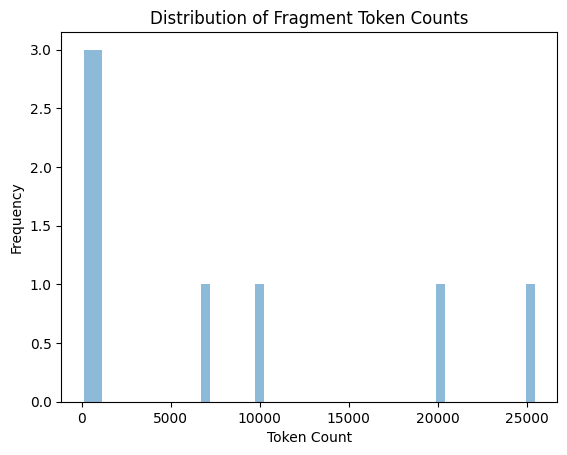

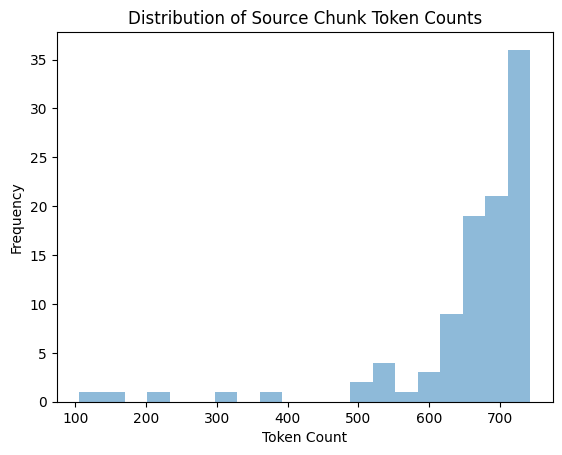

Общее количество чанков:  100


In [ ]:
source_chunks, fragments = split_text(markdown, 750)
print("Общее количество чанков: ",len(source_chunks))

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [ ]:
# ваше решение

system= load_document_text('https://docs.google.com/document/d/1S3YCL8r2-LyYMZzdg2V8HpZq-VgK3L2J/edit?usp=sharing&ouid=114366634982817564013&rtpof=true&sd=true')


In [ ]:
system

'\ufeffТы-консультант по техническому регламенту таможенного союза о безопасности железнодорожного подвижного состава. У тебя есть документ с информацией о регламенте. Тебе задает вопрос пользователь, ответь на данный вопрос, основываясь только на представленной тебе информации. Не добавляй ничего от себя. Если вопрос пользователя не связан с техническим регламентом таможенного союза о безопасности железнодорожного подвижного состава, то ответь пользователю, что ты не компетентен отвечать на подобные вопросы. Пользователь ничего не должен знать о представленных документах, на основании которых ты отвечаешь.'

In [ ]:
def answer_index(system, search_query, topic, search_index, verbose=1, relevance_threshold=0.3):
    # Поиск релевантных отрезков из базы знаний по вопросу пользователя с оценкой релевантности
    scored_docs = search_index.similarity_search_with_score(search_query, k=3)

    # Фильтрация документов, которые не соответствуют порогу релевантности
    relevant_docs = [(doc, score) for doc, score in scored_docs if score >= relevance_threshold]

    if verbose:
        print('\n===========================================: ')
        print(f'Filtered relevant documents based on threshold {relevance_threshold}:\n{relevant_docs}')

    # Формирование контента из отфильтрованных документов
    message_content = re.sub(r'\n{2}', ' ', '\n'.join([
        f'\nОтрывок документа №{i+1}\n===================== Score: {score}\n' + doc.page_content + '\n'
        for i, (doc, score) in enumerate(relevant_docs)
    ]))

    if verbose:
        print('message_content:\n========================================\n', message_content)

    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя. Документы с информацией для ответа клиенту: {message_content}\n\n{topic}"}
    ]

    if verbose:
        print('\n===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        temperature=0.3
    )

    answer = completion.choices[0].message.content
    return answer

In [ ]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя, тебе запрещено удалять из саммаризации имя пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        temperature=0,
    )

    return completion.choices[0].message.content

In [ ]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " +summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    answer_text = answer_index(system, user_question, topic, db)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


In [ ]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [ ]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', insert_newlines(answer))

    return

In [ ]:
run_dialog(system, db)

Пользователь: Кем должна производиться идентификация продукции? Может ли ее производить доверенное лицо от заявителя?

===========================================: 
Filtered relevant documents based on threshold 0.3:
[(Document(page_content='б) полное наименование заявителя, его место нахождения (адрес юридического лица) и адрес (адреса) места осуществления деятельности (если адреса различаются) - для юридического лица или фамилию, имя и отчество (при наличии), место жительства и адрес (адреса) места осуществления деятельности (если адреса различаются) - для физического лица, зарегистрированного в качестве индивидуального предпринимателя, а также регистрационный или учетный (индивидуальный, идентификационный) номер заявителя, присваиваемый при государственной регистрации юридического лица или физического лица, зарегистрированного в качестве индивидуального предпринимателя, в соответствии с законодательством государств-членов, банковские реквизиты, номер телефона и адрес электронной поч